In [1]:
pip install scikit-multiflow


2) loading mnist dataset

In [2]:
import tensorflow.keras.datasets.mnist as mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

3) make stream from mnist

In [3]:
from skmultiflow.data import DataStream
from skmultiflow.data import FileStream
from sklearn.preprocessing import StandardScaler
import numpy as np

x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))



# Normalize the features (X)
scaler_X = StandardScaler()
x_train = scaler_X.fit_transform(x_train)
print(x_train.shape)

# Combine the features and labels into a single array
train_data = np.column_stack((x_train, y_train))

# Shuffle the training data along the first axis (rows)
np.random.shuffle(train_data)

# Split the shuffled data back into features and labels
shuffled_X_train = train_data[:, :-1]
shuffled_y_train = train_data[:, -1]

stream = DataStream( shuffled_X_train , shuffled_y_train)

(60000, 784)


4 ) incremental learning for every datapoint in datastream and calculate accuracy

In [4]:
from skmultiflow.meta import AdaptiveRandomForestClassifier
from skmultiflow.evaluation import EvaluatePrequential
from sklearn.model_selection import GridSearchCV
from skmultiflow.data import DataStream
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Define the Adaptive Random Forest classifier
classifier = AdaptiveRandomForestClassifier()

max_samples = 5000
number_samples = 0
accuracies_overall = []  # List to store overall accuracies
accuracies_recent = []  # List to store accuracies for every 100 recent samples
correct_overall = 0  # Counter for the number of correctly classified samples in entire process
correct_recent = 0 # Counter for the number of correctly classified samples for every 100 recent samples

# Create a tqdm progress bar
progress_bar = tqdm(total=max_samples, desc='Processing Samples' , leave=False)

# Incremental learning loop

while number_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_pred = classifier.predict(X)
    if y[0] == y_pred[0]:
        correct_overall += 1
        correct_recent  += 1
    classifier.partial_fit(X, y)
    number_samples += 1

    # Calculate and store the overall accuracy
    overall_accuracy = correct_overall / number_samples
    accuracies_overall.append(overall_accuracy)

    # Calculate and store the accuracy for every 100 recent samples
    if number_samples % 100 == 0:
        recent_accuracy = correct_recent / 100
        accuracies_recent.append(recent_accuracy)
        correct_recent = 0  # Reset the counter for recent accuracy calculation
    # Update the progress bar
    progress_bar.update(1)
# Close the progress bar
progress_bar.close()




5 ) Plot the accuracy over the entire training process &&  Plot the accuracy for every 100 recent data points


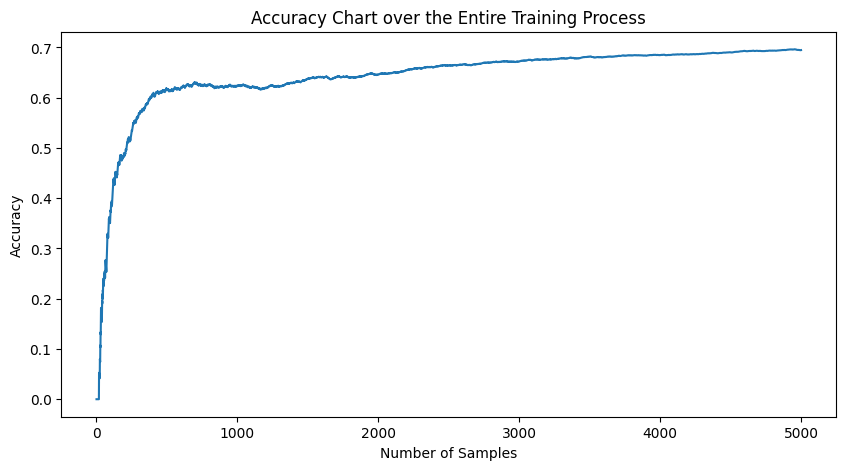

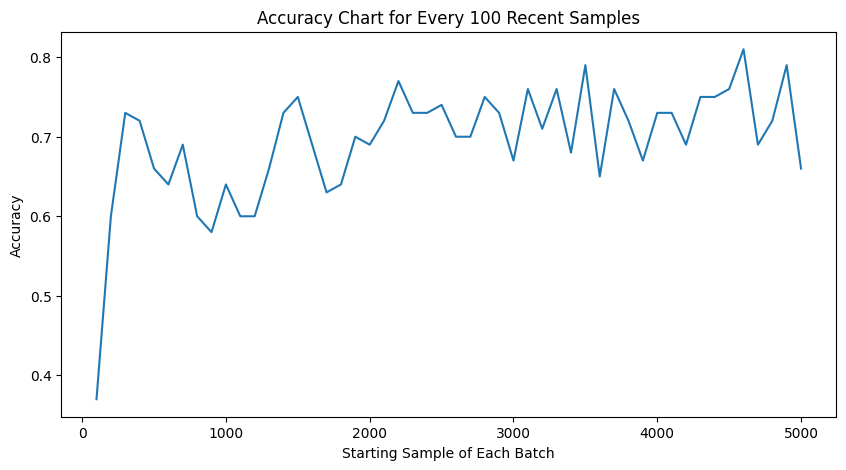

In [5]:
# Plotting the accuracy chart over the entire training process
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies_overall) + 1), accuracies_overall)
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy Chart over the Entire Training Process')
plt.show()

# Plotting the accuracy chart for every 100 recent samples
plt.figure(figsize=(10, 5))
plt.plot(range(100, len(accuracies_recent) * 100 + 1, 100), accuracies_recent)
plt.xlabel('Starting Sample of Each Batch')
plt.ylabel('Accuracy')
plt.title('Accuracy Chart for Every 100 Recent Samples')
plt.show()